# Imports

In [71]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Load the Image

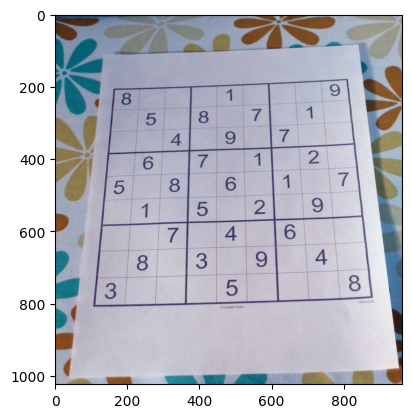

In [72]:
# req = urllib.request.urlopen('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSXWgbXAGTp-igspDP1qDo3aFJeE4vd_2u3Og&usqp=CAU')
req = urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg')
# req = urllib.request.urlopen('https://jump.dev/JuMP.jl/stable/assets/partial_sudoku.png')
# req = urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg')
# req = urllib.request.urlopen('https://cdn.britannica.com/42/97142-131-E3E24AA5/sudoku-puzzle-games.jpg')
# req = urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg')

arr = np.asarray(bytearray(req.read()), dtype=np.uint8) #transform image to array
img = cv2.imdecode(arr, -1) # 'Load it as it is'
# img = cv2.imread('/home/youssef/nagysudoku2.jpg')
plt.imshow(img, cmap="gray")

# Convert to Grayscale

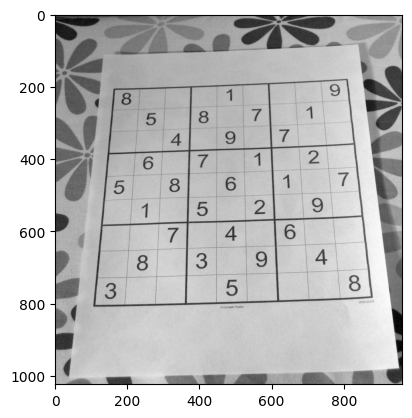

In [73]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap="gray") 

# Remove Noise using a 3x3 Gaussian Filter

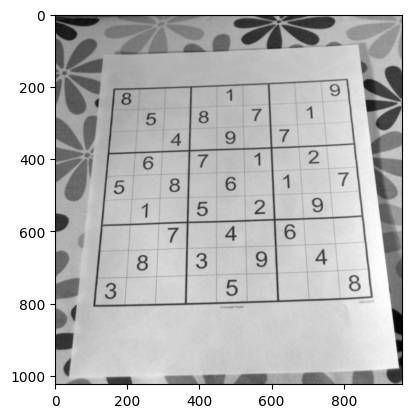

In [74]:
blurred = cv2.GaussianBlur(gray_image, (3, 3), cv2.BORDER_DEFAULT)
plt.imshow(blurred, cmap="gray")

# Adaptive Thresholding

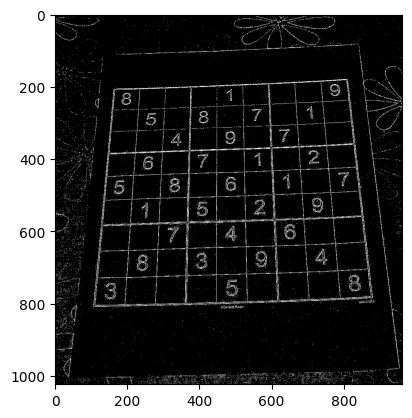

In [75]:
img_gray_threshed = cv2.adaptiveThreshold(src=gray_image,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=3,
    C=5
)
plt.imshow(img_gray_threshed, cmap="gray")

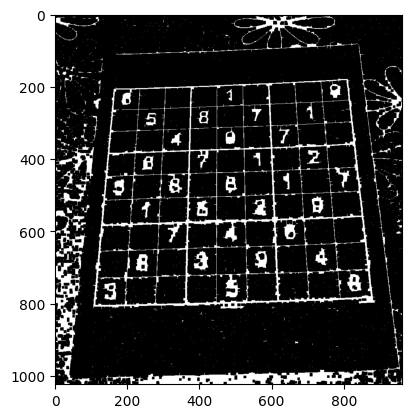

In [76]:
closed_grid = np.zeros_like(img_gray_threshed, dtype = np.uint8)
closed_grid = cv2.morphologyEx(img_gray_threshed, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
plt.imshow(closed_grid, cmap="gray")

# Get the largest object in the image using Cotours
## *It is assumed that the sudoku frame is the largest object in the image*

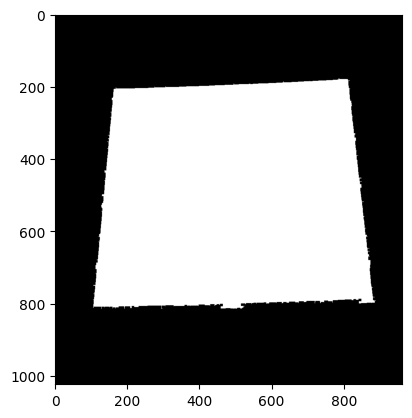

In [77]:

max = -1
x = -1
contours, _ = cv2.findContours(closed_grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
selected_contours = []
sudoku_square = np.zeros(img_gray_threshed.shape, np.uint8)
for i in range(len(contours)):
  area = cv2.contourArea(contours[i])
  if area > max:
     max = area
     x = i   

selected_contours.append(contours[x])
cv2.fillPoly(sudoku_square, pts=selected_contours, color= (255,255,255))
plt.imshow(sudoku_square, cmap="gray")

# Extract Edges using Canny

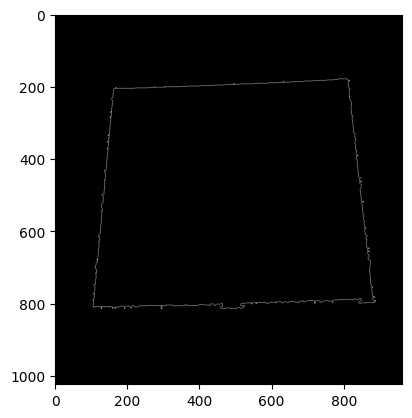

In [78]:
canny_img = cv2.Canny(sudoku_square, 50, 150)
plt.imshow(canny_img, cmap="gray")

# Remove Connected Components

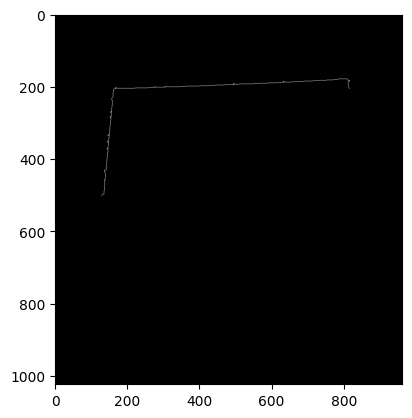

In [79]:
analysis = cv2.connectedComponentsWithStats(canny_img, 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 

output = np.zeros(gray_image.shape, dtype="uint8") 
  
for i in range(1, totalLabels): 
    # Area of the component 
    area = values[i, cv2.CC_STAT_AREA]  
      
    if (area > 400): 
        componentMask = (label_ids == i).astype("uint8") * 255
        output = cv2.bitwise_or(output, componentMask) 

plt.imshow(output, cmap="gray")

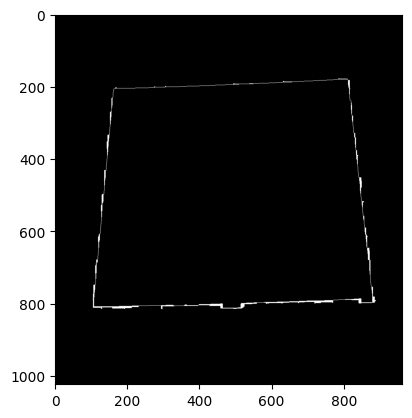

In [80]:
closed_grid = np.zeros_like(img_gray_threshed, dtype = np.uint8)
closed_grid = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25)))
plt.imshow(closed_grid, cmap="gray")

newimg = cv2.Canny(closed_grid, 50, 150)

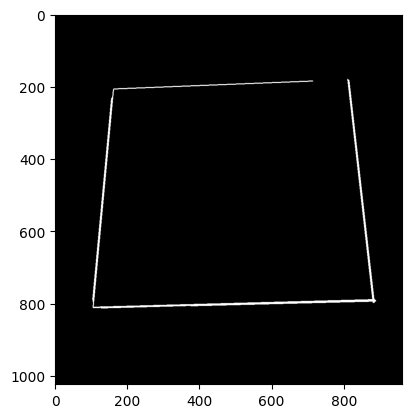

In [81]:
## Hough
minLineLength = min(img_gray_threshed.shape[0],img_gray_threshed.shape[1])/2
hough_linesy = cv2.HoughLinesP(
    image=closed_grid,
    rho=1,  # Distance resolution of the accumulator in pixels.
    theta=0.00115,  # Angle resolution of the accumulator in radians.
    threshold=150,  # Voting threshold for accumulator.
    lines=None,
    minLineLength=minLineLength,  #  Line segments shorter than that are rejected.
    maxLineGap=150 # Maximum allowed gap between points on the same line to link them.
)
for x0, y0, x1, y1 in hough_linesy[:,0]:
    cv2.line(img_gray_threshed, (x0, y0), (x1, y1), (255,0,0), 2, cv2.LINE_AA)
tmp_imgy = np.zeros_like(img_gray_threshed, dtype = np.uint8)
for x1, y1, x2, y2 in hough_linesy[:,0]: cv2.line(tmp_imgy,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(tmp_imgy, cmap='gray')

# Get the corners using Harris

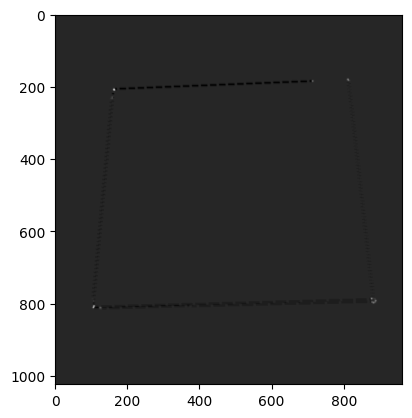

In [82]:
# blurred = cv2.GaussianBlur(tmp_imgy, (7, 7), 0)


# plt.imshow(tmp_imgy, cmap="gray")
dest = cv2.cornerHarris(tmp_imgy, 7, 3, 0.04) 
  

# Results are marked through the dilated corners 
# dest = cv2.dilate(dest, None) 
  
# Reverting back to the original image, 
# with optimal threshold value 

plt.imshow(dest, cmap="gray")

# Apply a Gaussian Filter, get the absolute values, then Threshhold to only get the corner points

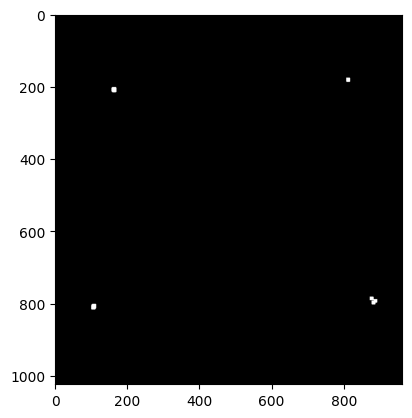

In [83]:
Gaussian_box = cv2.GaussianBlur(dest,(7,7), 0)
#plt.imshow(Gaussian_box, cmap='gray');
Gaussian_box = np.abs(Gaussian_box)
#plt.imshow(Gaussian_box, cmap='gray');

# for i in range(Gaussian_box.shape[0]):
#     for j in range(Gaussian_box.shape[1]):
#         if Gaussian_box[i][j] > 0:
#             print(Gaussian_box[i][j])
ret, thresh1 = cv2.threshold(Gaussian_box, 0.02, 255, cv2.THRESH_BINARY) 
#####

# plt.imshow(thresh1, cmap="gray")

dest = cv2.cornerHarris(thresh1, 7, 3, 0.04) 

dest = np.abs(dest)
# print(dest[30])
ret, thresh1 = cv2.threshold(dest, 0, 255, cv2.THRESH_BINARY) 

plt.imshow(thresh1, cmap="gray")
# print(dest[209])

# plt.imshow(dest, cmap="gray")

# plt.imshow(thresh1, cmap='gray')

# Get the coordinates of the Corners

In [84]:
# # coords = []


# # print(dest.shape)

# # for i in range(dest.shape[0]):
# #     for j in range(dest.shape[1]):

# #         if len(coords) > 0:
# #             rx = coords[-1][0] - i
# #             ry = coords[-1][1] - j
# #             rx = np.abs(rx)
# #             ry = np.abs(ry)
# #             # print(rx)
# #             # print(ry)
# #             if rx < dest.shape[0] / 2 and ry < dest.shape[1] / 2:
                
# #                 continue
# #         if dest[i][j] > 0:
# #             temp = (i, j)
# #             # print(temp)
# #             coords.append(temp)
# #             # j += dest.shape[1] / 2
            
    
center_point = (dest.shape[0] // 2, dest.shape[1] // 2)

left_part = dest[:, :center_point[1]]

right_part = dest[:, center_point[1]:]


top_left_part = left_part[:center_point[0], :]
bottom_left_part = left_part[center_point[0]:, :]

top_right_part = right_part[:center_point[0], :]
bottom_right_part = right_part[center_point[0]:, :]

c1 = (-1, -1)
found = False
for i in range(len(top_left_part)):
    for j in range(len(top_left_part[0])):
        if top_left_part[i][j] > 0:
            c1 = (i+10, j+10)
            found = True
            break
    if found:
        break

print(c1)

c2 = (-1, -1)
found = False
for i in range(len(top_right_part)):
    for j in range(len(top_right_part[0])):
        if top_right_part[i][j] > 0:
            c2 = (i+10, j + center_point[1]+10)
            found = True
            break
    if found:
        break

print(c2)

c3 = (-1, -1)
found = False
for i in range(len(bottom_left_part)):
    for j in range(len(bottom_left_part[0])):
        if bottom_left_part[i][j] > 0:
            c3 = (i + center_point[0]+10, j+10)
            found = True
            break
    if found:
        break

print(c3)

c4 = (-1, -1)
found = False
for i in range(len(bottom_right_part)):
    for j in range(len(bottom_right_part[0])):
        if bottom_right_part[i][j] > 0:
            c4 = (i + center_point[0]+10, j + center_point[1]+10)
            found = True
            break
    if found:
        break

print(c4)


# plt.imshow(bottom_right_part)

# q1 = thresh1[0:,:center_point[0]][:center_point[1],0:]

# q2 = thresh1[center_point[0]:thresh1.shape[0],]
# plt.imshow(q1)

# print(coords)

# maxY = -1
# maxYi = -1
# for i in range(len(coords)):
#     if maxY < coords[i][0]:
#         maxY = coords[i][0]
#         maxYi = i
# # print(coords)
# # print(maxYi)

# n = -1
# for i in range(len(coords)):
#     if np.abs(maxY - coords[i][0]) != 0 and np.abs(maxY - coords[i][0]) < 50 and i != maxYi:
#         n = i
# c3 = (-1, -1)
# c4 = (-1, -1)
# if coords[maxYi][1] > coords[n][1]:
#     c3 = coords[n]
#     c4 = coords[maxYi]
# else:
#     c4 = coords[n]
#     c3 = coords[maxYi]

# # print(c3)
# # print(c4)


# minY = 99999
# minYi = 99999
# for i in range(len(coords)):
#     if minY > coords[i][0]:
#         minY = coords[i][0]
#         minYi = i

# n = -1
# for i in range(len(coords)):
#     if np.abs(minY - coords[i][0]) != 0 and np.abs(minY - coords[i][0]) < 100 and i != minYi:
#         n = i
# c1 = (-1, -1)
# c2 = (-1, -1)
# if coords[minYi][1] > coords[n][1]:
#     c1 = coords[n]
#     c2 = coords[minYi]
# else:
#     c2 = coords[n]
#     c1 = coords[minYi]

# print(coords)

# # print(c1)
# # print(c2)
# # print(c3)
# # print(c4)

(212, 168)
(186, 815)
(812, 113)
(792, 880)


# Perspective Transform

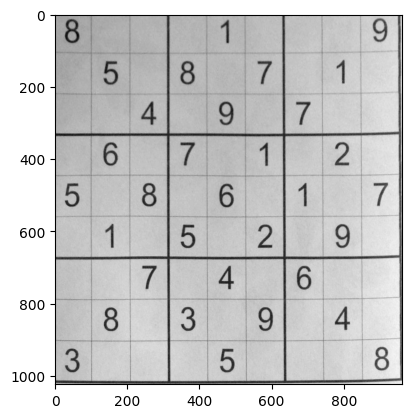

In [85]:


# y, x = img_gray_threshed.shape
# src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
# dst_coords = np.float32([[c1[::-1], c2[::-1], c4[::-1], c3[::-1]]])
# img_gray_threshed_warped = cv2.warpPerspective(
#     src=img_gray_threshed,
#     M=cv2.getPerspectiveTransform(dst_coords, src_coords),
#     dsize=img_gray_threshed.shape[::-1]
# )
# plt.imshow(img_gray_threshed_warped, cmap="gray");
# pts1 = np.float32([c1[::-1], c2[::-1],
#                        c3[::-1], c4[::-1]])
# # pts2 = np.float32([[0, 0], [400, 0],
#                       # [0, 640], [400, 640]])
     
# # Apply Perspective Transform Algorithm
# matrix = cv2.getPerspectiveTransform(pts1, src_coords)
# result = cv2.warpPerspective(img_gray_threshed, matrix, img_gray_threshed.shape)

# plt.imshow(result, cmap='gray')



input_points = np.float32([c1[::-1], c2[::-1], c3[::-1], c4[::-1]])
width = img.shape[1]
height = img.shape[0]

converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
# print(matrix)
img_output = cv2.warpPerspective(gray_image, matrix, (width, height))
plt.imshow(img_output, cmap="gray")





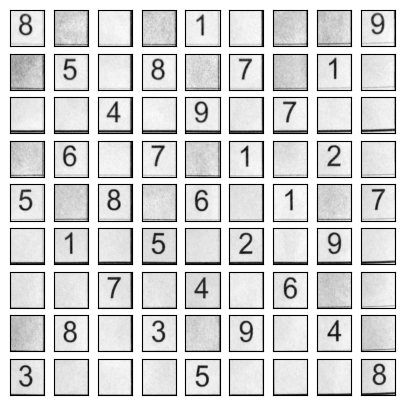

In [86]:
M = img_output.shape[0] // 9
N = img_output.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_output[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)